# Simple 3-Bus AC Power Flow Example
This notebook solves a simple 3-bus AC power flow problem. This example follows the Newton-Raphson method described in pages 106-123 of the lecture notes <a href="https://web.engr.oregonstate.edu/~webbky/ESE470_files/Section%205%20Power%20Flow.pdf">here</a>.

In [1]:
# load packages
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path
import functions_3bus # load function for network
import pandas as pd
import numpy as np
import math
import cmath
import jax
import jax.numpy as jnp

### Power Flow Background
The goal here is to solve for the unknowns in the power flow equations for each bus $i$ in an $N$-bus network:
\begin{gather*}
P_{i} = V_{i} \sum_{j=1}^{J} Y_{ij} V_{j} cos(\delta_{i} - \delta_{j} - \theta_{ij})\\
Q_{i} = V_{i} \sum_{j=1}^{J} Y_{ij} V_{j} sin(\delta_{i} - \delta_{j} - \theta_{ij})\\
i = 1,2,...,N
\end{gather*}
where

$P_{i}$ and $Q_{i}$ are the real and reactive power, respectively, injected at bus $i$

$V_{i}$ and $\delta_{i}$ are the voltage magintude and phase angle, respectively, at bus $i$

$Y_{ij}$ and $\theta_{ij}$ are the admittance magnitude and angle, respectively, of the branch between buses $i$ and $j$

For derivation of the equations, see pages 18-20 of the lecture notes <a href="https://web.engr.oregonstate.edu/~webbky/ESE470_files/Section%205%20Power%20Flow.pdf">here</a> or Glover and Sarma's Power System Analysis and Design, third edition, pages 280-281.

Each bus has four quantities: $P$, $Q$, $V$, and $\delta$. Depending on the bus type, these quantities are known or unknown. Generator buses are PV buses, where the real power (P) and voltage magnitude (V) are known and the reactive power (Q) and voltage phase angle ($\delta$) are unknown. Load buses are PQ buses, where real power (P) and reactive power (Q) are known and the voltage magnitude (V) voltage phase angle ($\delta$) are unknown. The slack bus (typically a generator) is used to balance power flows on the network, and the voltage magnitude and phase angle are set at $1.0\angle0\degree$

| Bus Type | Knowns | Unknowns |
|----------|--------|----------|
| Slack | V, $\delta$ | P,Q |
| PV | P,V | Q, $\delta$ |
| PQ | P,Q | V, $\delta$ |




## Network
The network has 3 buses: bus 1 is the slack bus, bus 2 is a PV bus, and bus 3 is a PQ bus. The diagram for the network is shown below.

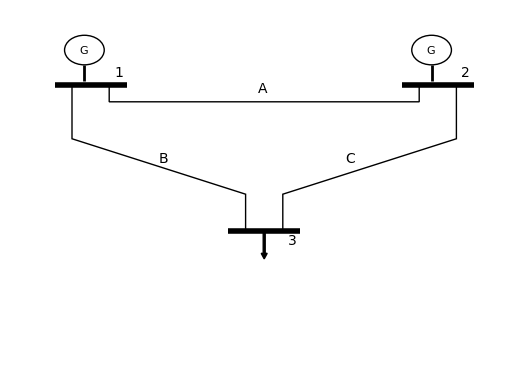

In [3]:
functions_3bus.create_fig_3bus(np.empty(3,dtype='object'))

## Build the Admittance Matrix

In [5]:
# input admittances for the tranmission lines
# here we have no shunt admittances
admittances_input = {(1,2):2.06-1j*20.9,(1,3):1.54-1j*15.7,(2,3):2.06-1j*20.9}
# build the admittance matrix Y, where I = YV
Y = np.zeros((3,3), dtype=complex)
for i in range(3):
    for j in range(3):
        if i==j: 
            for k in range(len(admittances_input)):
                if (min(i+1,k+1),max(i+1,k+1)) in admittances_input:
                    Y[i,j] += admittances_input[(min(i+1,k+1),max(i+1,k+1))]
        else: Y[i,j] = -admittances_input[(min(i+1,j+1),max(i+1,j+1))]

In [7]:
Y_mag = np.abs(Y)
print("Admittance Magnitude:\n", Y_mag)
Y_angle =  np.angle(Y)
print("Admittance Angle (rad):\n", Y_angle)

Admittance Magnitude:
 [[36.77662301 21.00127615 15.77534786]
 [21.00127615 42.0025523  21.00127615]
 [15.77534786 21.00127615 36.77662301]]
Admittance Angle (rad):
 [[-1.47275105  1.66904358  1.66857271]
 [ 1.66904358 -1.47254907  1.66904358]
 [ 1.66857271  1.66904358 -1.47275105]]


In [9]:
# admittances magnitudes and phase angles used in Jacobian
Y_mag21 = Y_mag[1,0]
Y_mag22 = Y_mag[1,1]
Y_mag23 = Y_mag[1,2]
Y_mag31 = Y_mag[2,0]
Y_mag32 = Y_mag[2,1]
Y_mag33 = Y_mag[2,2]
theta21 = Y_angle[1,0]
theta22 = Y_angle[1,1]
theta23 = Y_angle[1,2]
theta31 = Y_angle[2,0]
theta32 = Y_angle[2,1]
theta33 = Y_angle[2,2]

## Intialize Knowns and Unknowns

In [11]:
# Knowns
V1 = 1.0 # voltage magnitude at bus 1
d1 = 0 # phase angle at bus 1
P2 = 2.0 # real power net inj at bus 2
V2 = 1.05 # voltage magnitude at bus 2
P3 = -5.0 # real power net inj at bus 3 
Q3 = -1.0 # reactive power net inj at bus 

# Unknowns
d2 = 0 # phase angle at bus 2
d3 = 0 # phase angle at bus 3
V3 = 1.0 # voltage magnitude at phase 3

## Run algorithm
The goal of this algorithm is the find **x** s.t. **f**(**x**) = **y**, where f is the set of nonlinear power equations. It uses the first-order Taylor Series expansion of f about a point x=a to approximate the value of x where f(x) = y. Page 54 <a href="https://web.engr.oregonstate.edu/~webbky/ESE470_files/Section%205%20Power%20Flow.pdf">here</a> has a nice visual representation of this. In each iteration of the alogrithm, check if f(x) is close enough to y, and if it is we are done.

In [13]:
# set up algorithm parameters 
max_itr = 10
error_tol = 0.0001
itr = 0

In [15]:
# calculate initial power mismatch
V = np.array([V1*math.cos(d1)+1j*V1*math.sin(d1),V2*math.cos(d2)+1j*V2*math.sin(d2),V3*math.cos(d3)+1j*V3*math.sin(d3)]) # voltages
I = np.matmul(Y,V) # current injections
S = V*np.conjugate(I) # complex power net injections
f_x = np.array([S[1].real,S[2].real,S[2].imag]) # calculated power net inj
y = np.array([P2,P3,Q3]) # known power net injections
dy = y - f_x # power mismatch
mismatch = max(np.abs(dy))

In [17]:
# define the nonlinear power flow equations
def f(x):
    return jnp.array(
    [V2*Y_mag21*V1*jnp.cos(x[0]-d1-theta21) + V2*Y_mag23*x[2]*jnp.cos(x[0]-x[1]-theta23)
      + V2*Y_mag22*V2*jnp.cos(x[0]-x[0]-theta22),
     x[2]*Y_mag31*V1*jnp.cos(x[1]-d1-theta31) + x[2]*Y_mag32*V2*jnp.cos(x[1]-x[0]-theta32)
     + x[2]*Y_mag33*x[2]*jnp.cos(x[1]-x[1]-theta33),
     x[2]*Y_mag31*V1*jnp.sin(x[1]-d1-theta31) + x[2]*Y_mag32*V2*jnp.sin(x[1]-x[0]-theta32)
    + x[2]*Y_mag33*x[2]*jnp.sin(x[1]-x[1]-theta33)])
# set initial variables
x = jnp.array([d2,d3,V3])

In [19]:
# while power mismatch is greater than tolerance and 
# iter count less than max iterations, continue alogrithm
while mismatch > error_tol and itr < max_itr:
    # compute Jacobian
    jac = jax.jacfwd(f)(x)
    # solve for delta x: dy = Jdx
    dx = np.linalg.solve(jac,dy)
    # update x
    x = x + dx
    V[1] = V2*math.cos(x[0]) + 1j*V2*math.sin(x[0]) # update voltages
    V[2] = x[2]*math.cos(x[1]) + 1j*x[2]*math.sin(x[1]) 
    # calculate power mismatch
    I = np.matmul(Y,V) # current injections
    S = V*np.conjugate(I) # complex power
    f_x = np.array([S[1].real,S[2].real,S[2].imag]) # calculated power inj
    dy = y - f_x # mismatch
    mismatch = max(np.abs(dy))
    print('Iteration ', itr+1, "Mismatch : ", mismatch)
    print('Convergence of known power injections:\n',
     'P1: ', y[0],' vs. ', S[1].real, '\n',
     'P2: ', y[1],' vs. ', S[2].real, '\n',
     'Q2: ', y[2],' vs. ', S[2].imag)
    itr = itr + 1

Iteration  1 Mismatch :  0.31233218578457167
Convergence of known power injections:
 P1:  2.0  vs.  1.979439575521429 
 P2:  -5.0  vs.  -4.895576058007976 
 Q2:  -1.0  vs.  -0.6876678142154283
Iteration  2 Mismatch :  0.003296136105946479
Convergence of known power injections:
 P1:  2.0  vs.  1.999449832680366 
 P2:  -5.0  vs.  -4.998477481628849 
 Q2:  -1.0  vs.  -0.9967038638940535
Iteration  3 Mismatch :  1.2660655168694745e-07
Convergence of known power injections:
 P1:  2.0  vs.  1.9999999546961884 
 P2:  -5.0  vs.  -4.999999929328084 
 Q2:  -1.0  vs.  -1.0000001266065517


In [21]:
# calculate branch flows- see Wood, Wollenberg, and Sheble (2014) Power Generation, Operation, and Control, 3rd Ed
def flw(br,pwr_type='r'):
    s = br[0]
    r = br[1]
    Vs = np.abs(V[s-1])
    Vr = np.abs(V[r-1])
    Y_mag_sr = Y_mag[s-1,r-1]
    theta_sr = Y_angle[s-1,r-1]
    dr = np.angle(V[r-1])
    ds = np.angle(V[s-1])
    if (pwr_type == 'r'):
        flw_sr = -Vs*Y_mag_sr*Vs*math.cos(-theta_sr) + Vs*Y_mag_sr*Vr*math.cos(ds-dr-theta_sr)
    else: flw_sr = -Vs*Y_mag_sr*Vs*math.sin(-theta_sr) + Vs*Y_mag_sr*Vr*math.sin(ds-dr-theta_sr)
    return flw_sr
# real and reactive flows
bus_links = list(zip(np.array([1,2,1,3,2,3]),np.array([2,1,3,1,3,2])))
real_pwr = np.round(list(map(flw,bus_links,'r'*len(bus_links))),3)
reactive_pwr = np.round(list(map(flw,bus_links,'q'*len(bus_links))),3)

## Results Summary

In [23]:
# nodal quantities- complex power injections and bus voltages
buses = [1,2,3]
bus_type = ['Slack','PV','PQ']

# voltages
volt_angles = np.char.add(np.round(np.angle(V,deg=True),1).astype(str), '\u00B0')
volt_mag = np.char.add(np.round(np.abs(V),3).astype(str), '\u2220')
vol_polar = np.char.add(volt_mag,volt_angles)
bus_df = pd.DataFrame({'Bus':buses,'Type':bus_type, 'Complex Power':S, 'Voltage':vol_polar})
bus_df

,Bus,Type,Complex Power,Voltage
0,1,Slack,3.083666-0.815480j,1.0∠0.0°
1,2,PV,2.000000+2.666093j,1.05∠-2.1°
2,3,PQ,-5.000000-1.000000j,0.978∠-8.8°


In [25]:
# branch power flows
line = ['A','B','C']
bus_to_bus = [('A','1 to 2'), ('A','2 to 1'), ('B','1 to 3'), ('B','3 to 1'), ('C','2 to 3'), ('C','3 to 2')]
flow_index = pd.MultiIndex.from_tuples(bus_to_bus, names=['Line','Bus to Bus'])
flow_df = pd.DataFrame({'P':real_pwr,'Q':reactive_pwr}, index=flow_index)
flow_df
# differences between receiving end power and sending end power are line losses

P      Q
Line Bus to Bus              
A    1 to 2      0.688 -1.109
     2 to 1     -0.680  1.189
B    1 to 3      2.395  0.293
     3 to 1     -2.359  0.074
C    2 to 3      2.680  1.477
     3 to 2     -2.641 -1.074

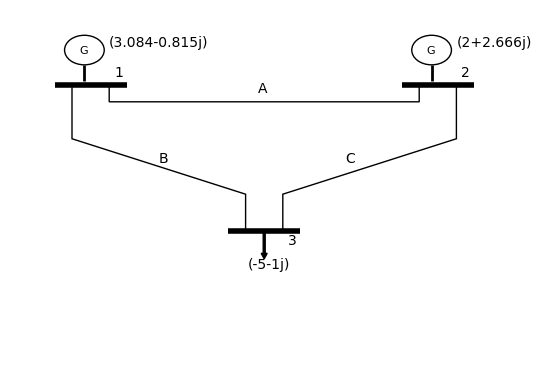

In [27]:
functions_3bus.create_fig_3bus(np.round(S,3))